In [31]:
import mplfinance as mpf
import pandas as pd
from alpha_vantage.timeseries import TimeSeries
import matplotlib.pyplot as plt
import concurrent.futures

In [32]:
def get_time_series():
    API_key = 'MCO3JQL81ATB1YZ0'
    time = TimeSeries(key = API_key,output_format='pandas')
    return time

In [33]:
def average(lst): #calculates and returns mean of a list
    if len(lst):
        return sum(lst) / len(lst)
    else:
        return sum(lst)

In [34]:
def get_data_frame(ticker, cash, vwap=0, twap=0):
    time = get_time_series()
    data = time.get_intraday(symbol=ticker,interval='1min',outputsize='full')
    df = data[0]
    df = df.rename(columns={"1. open":"Open","2. high":"High","3. low":"Low","4. close":"Close","5. volume":"Volume"})
    result = [group[1] for group in df.groupby(df.index.day)]
    
    for index, dataframe in enumerate(result):
        index += 1
        
        dataframe = dataframe.loc[(dataframe.index.hour >= 9)]
        dataframe = dataframe.loc[(dataframe.index.hour <= 15)]
        dataframe = dataframe.resample('5T').agg({'Open':'first','High':'max','Low':'min','Close':'last','Volume':'sum'})
        
        
        if vwap:    
            dataframe['VWAP'] = (((dataframe['High']+dataframe['Low']+dataframe['Close'])*dataframe['Volume']/3).cumsum())/dataframe['Volume'].cumsum()
        if twap:
            df_open = dataframe['Open'].tolist()
            df_high = dataframe['High'].tolist()
            df_low = dataframe['Low'].tolist()
            df_close = dataframe['Close'].tolist()
            
            new_list = []
            
            
            for i in range(0, len(df_open)):
                twap_data = (average(df_open[0:i])+average(df_high[0:i])+average(df_low[0:i])+average(df_close[0:i]))/4
                new_list.append(twap_data)
            
            new_list[0] = df_open[0]
            
            
            dataframe['TWAP'] = new_list
            
        
        dataframe = dataframe.dropna()
        
        
        #print(dataframe['TWAP'].tolist())
        #print(dataframe['TWAP'])
        #type(dataframe['TWAP'])
        yield dataframe
     



In [35]:
def plot_data_frame(ticker, cash, add_vwap=0, add_twap=0): # by default, add_vwap and add_twap are false
    
    #generator object
    dataframe= get_data_frame(ticker, cash, add_vwap, add_twap)
    
    #loops through dataframe for each day
    for df in dataframe:
        #print(df)
        #plots is a list of our mpf plots
        plots = []
        
        if add_vwap:
            vwap = mpf.make_addplot(df['VWAP'])
            #plots.append(vwap)
        
        if add_twap:
            twap = mpf.make_addplot(df['TWAP'])
            plots.append(twap)
            
        #plot charts
        mpf.plot(df,addplot=plots,type='candle',style='yahoo',volume=True,title=f"{df.index.date[0]} {ticker}")
        
        #Strategies Go Here
        twap_strategy(0, 60, 3, 6, df['TWAP'].tolist(), df['VWAP'].tolist(), df['Open'].tolist()) #first 60 minutes, execute over three periods, pass vwap list, df
    

In [36]:
#start and end define the specified time period
#nbuckets tells how many buckets to divide trade into
#ntrades is how many trades we want to make over the time period
#t_list is the list of TWAP data 
#v_list is the list of VWAP data
#p_list is the list of prices
#df is the entire dataframe
def twap_strategy(start, end, nbuckets, ntrades, t_list, v_list, p_list): 
    #print start and end TWAP values for period
    print(f"Period's starting TWAP value: {time_retrieve(t_list,start)}")
    print(f"Period's ending TWAP value: {time_retrieve(t_list,end)}")
    
    trades_per_bucket = ntrades/nbuckets
    timediff = end-start

    #
    b_start = start #
    b_end = start + timediff/nbuckets #marks end of bucket period
    
    #buys
    for bucket in range(nbuckets):
        for trade in range(int(trades_per_bucket)):
            for time in range(int(b_start), int(b_end), 5): #increment through 5 minute intervals
                if (time_retrieve(p_list,time) <= time_retrieve(v_list,start)) and (time_retrieve(p_list,time) <= time_retrieve(t_list,start)) and (time_retrieve(v_list,time) <= time_retrieve(t_list,start)):
                    print(f'Purchased one share for {time_retrieve(p_list,time)}')
                if (time_retrieve(p_list,time) >= time_retrieve(v_list,start)) and (time_retrieve(p_list,time) >= time_retrieve(t_list,start)) and (time_retrieve(v_list,time) >= time_retrieve(t_list,start)):
                    print(f'Sold one share for {time_retrieve(p_list,time)}')
                    continue
        b_start = b_start + timediff/nbuckets
        b_end = b_end + timediff/nbuckets

In [37]:
def multi(ticker, cash, cores, add_vwap=0, add_twap=0):
    
    with concurrent.futures.ProcessPoolExecutor(cores) as executor:
        
        return plot_data_frame(ticker, cash, add_vwap, add_twap)

In [38]:
def timetolist(time): 
    #function converts a time in minutes to integer to reference list where elements are stored in 5 min intervals    
    return time/5

In [39]:
def time_retrieve(l, time): #where l is a list, time is time in minutes (from 9:00), 
    #fxn returns value from list
    return l[int(timetolist(time))]

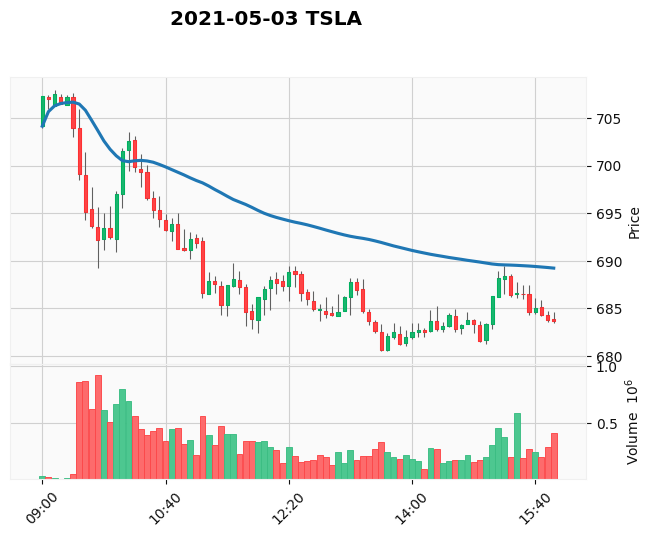

Period's starting TWAP value: 704.16
Period's ending TWAP value: 701.0482708333334
Sold one share for 707.21
Sold one share for 706.3
Sold one share for 707.22
Sold one share for 707.21
Sold one share for 706.3
Sold one share for 707.22
Sold one share for 706.4
Sold one share for 707.25
Purchased one share for 704.0
Purchased one share for 699.0
Sold one share for 706.4
Sold one share for 707.25
Purchased one share for 704.0
Purchased one share for 699.0
Purchased one share for 695.5
Purchased one share for 693.61
Purchased one share for 692.31
Purchased one share for 693.475
Purchased one share for 695.5
Purchased one share for 693.61
Purchased one share for 692.31
Purchased one share for 693.475


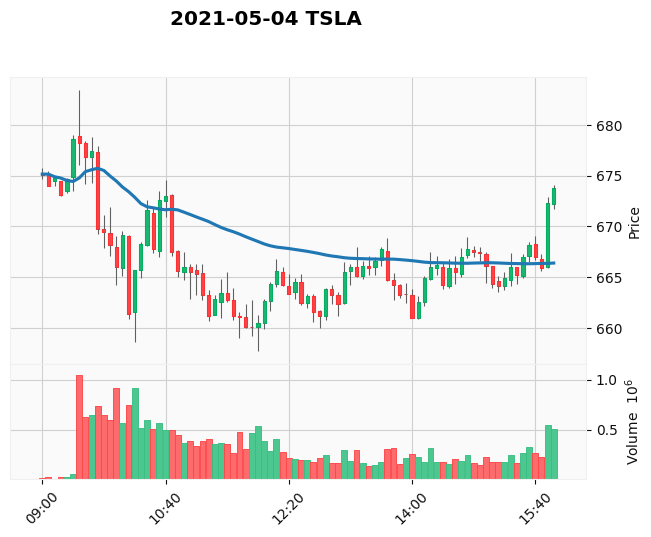

Period's starting TWAP value: 675.15
Period's ending TWAP value: 674.4720562499999
Purchased one share for 675.02
Purchased one share for 674.45
Purchased one share for 674.4999
Purchased one share for 675.02
Purchased one share for 674.45
Purchased one share for 674.4999
Purchased one share for 673.44
Sold one share for 678.87
Sold one share for 678.196
Purchased one share for 673.44
Sold one share for 678.87
Sold one share for 678.196
Sold one share for 676.8166
Sold one share for 677.3123
Purchased one share for 669.32
Sold one share for 676.8166
Sold one share for 677.3123
Purchased one share for 669.32


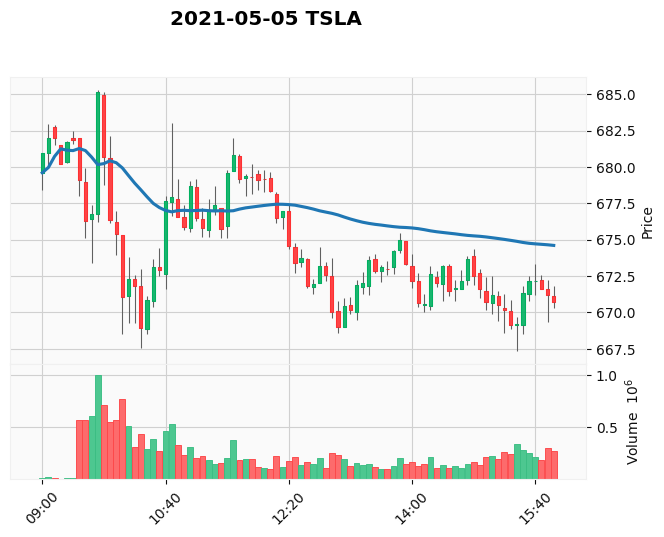

Period's starting TWAP value: 679.6
Period's ending TWAP value: 680.2881749999999
Sold one share for 680.93
Sold one share for 682.73
Sold one share for 681.5
Sold one share for 680.93
Sold one share for 682.73
Sold one share for 681.5
Sold one share for 680.33
Sold one share for 681.99
Sold one share for 682.0
Purchased one share for 678.98
Sold one share for 680.33
Sold one share for 681.99
Sold one share for 682.0
Purchased one share for 678.98
Purchased one share for 676.4299
Purchased one share for 676.7499
Sold one share for 684.94
Purchased one share for 676.4299
Purchased one share for 676.7499
Sold one share for 684.94


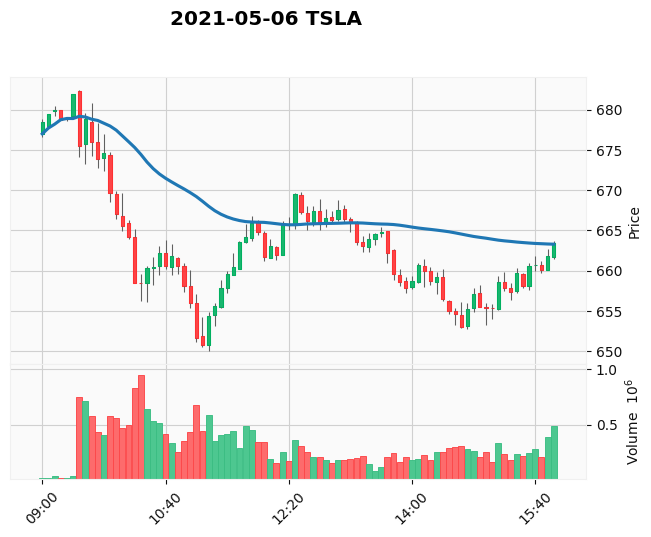

Period's starting TWAP value: 677.0
Period's ending TWAP value: 677.4622958333334
Sold one share for 678.0
Sold one share for 679.8108
Sold one share for 680.0
Sold one share for 678.0
Sold one share for 679.8108
Sold one share for 680.0
Sold one share for 678.9
Sold one share for 679.28
Sold one share for 682.3
Sold one share for 678.9
Sold one share for 679.28
Sold one share for 682.3
Sold one share for 678.53
Purchased one share for 675.97
Purchased one share for 674.05
Purchased one share for 674.38
Sold one share for 678.53
Purchased one share for 675.97
Purchased one share for 674.05
Purchased one share for 674.38


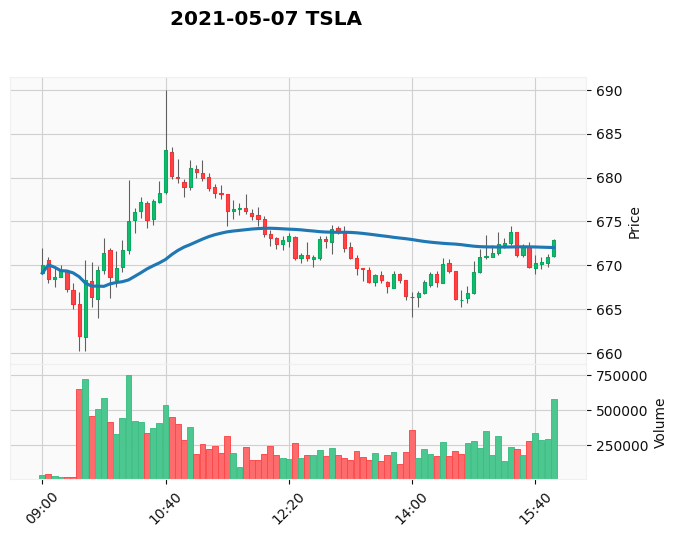

Period's starting TWAP value: 669.12
Period's ending TWAP value: 668.0439166666666
Sold one share for 670.63
Sold one share for 670.63
Purchased one share for 667.16
Purchased one share for 665.6
Purchased one share for 661.8
Purchased one share for 667.16
Purchased one share for 665.6
Purchased one share for 661.8
Purchased one share for 668.18
Purchased one share for 666.22
Purchased one share for 668.18
Purchased one share for 666.22


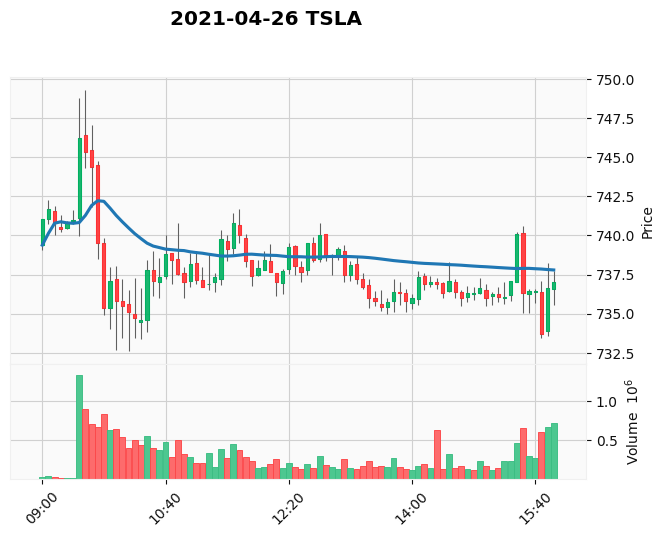

Period's starting TWAP value: 739.38
Period's ending TWAP value: 741.2762937499999
Sold one share for 741.05
Sold one share for 741.5407
Sold one share for 740.51
Sold one share for 741.05
Sold one share for 741.5407
Sold one share for 740.51
Sold one share for 740.49
Sold one share for 740.9
Sold one share for 741.14
Sold one share for 746.3871
Sold one share for 740.49
Sold one share for 740.9
Sold one share for 741.14
Sold one share for 746.3871
Sold one share for 745.4367
Sold one share for 744.475
Sold one share for 745.4367
Sold one share for 744.475


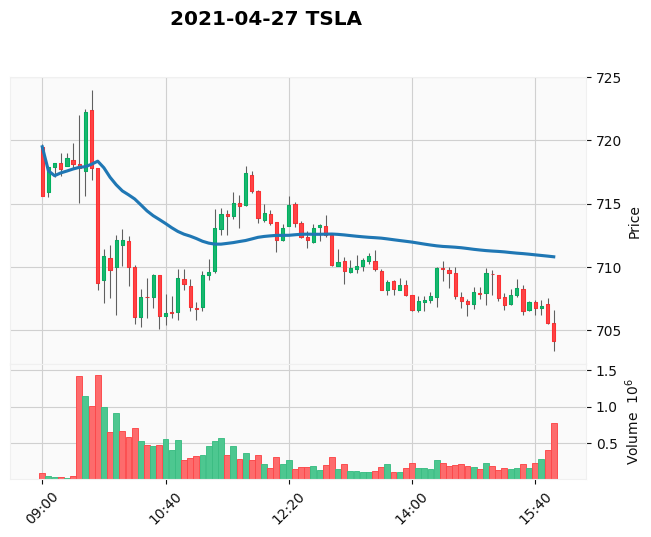

Period's starting TWAP value: 719.5
Period's ending TWAP value: 716.4972916666667
Purchased one share for 715.94
Purchased one share for 715.94
Purchased one share for 708.9999
Purchased one share for 710.7001
Purchased one share for 708.9999
Purchased one share for 710.7001


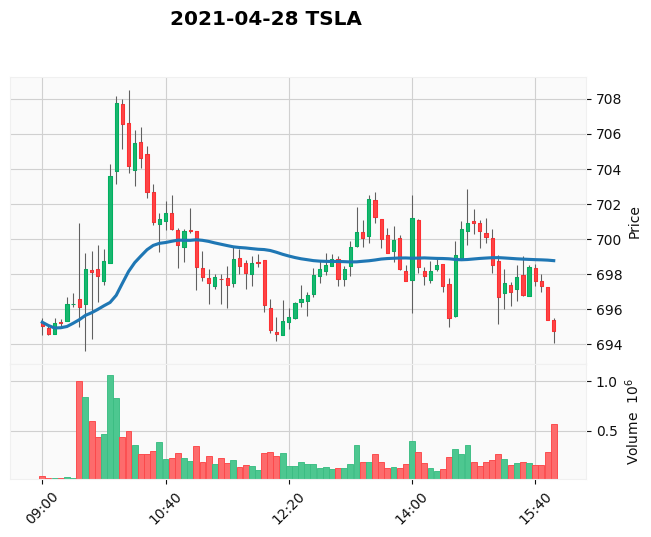

Period's starting TWAP value: 695.25
Period's ending TWAP value: 696.7870541666667
Purchased one share for 694.95
Purchased one share for 694.6
Purchased one share for 694.95
Purchased one share for 694.6
Sold one share for 696.3
Sold one share for 696.55
Sold one share for 696.278
Sold one share for 696.3
Sold one share for 696.55
Sold one share for 696.278
Sold one share for 698.21
Sold one share for 698.28
Sold one share for 697.62
Sold one share for 698.6297
Sold one share for 698.21
Sold one share for 698.28
Sold one share for 697.62
Sold one share for 698.6297


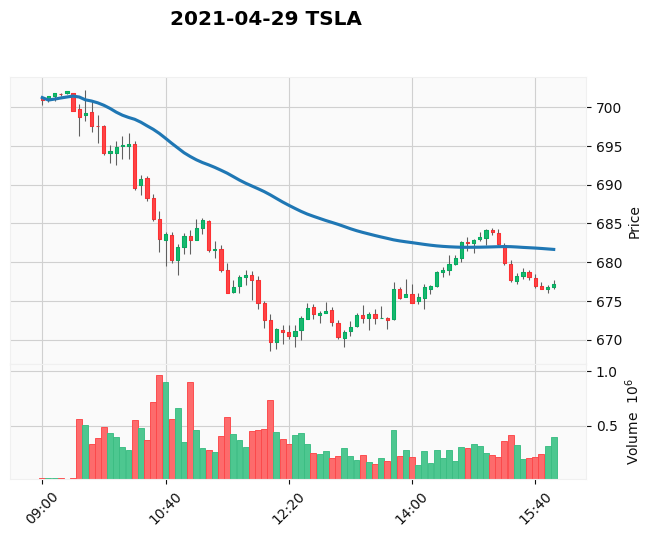

Period's starting TWAP value: 701.25
Period's ending TWAP value: 699.3693375
Sold one share for 701.73
Sold one share for 701.73
Sold one share for 701.8
Purchased one share for 699.75
Purchased one share for 699.04
Sold one share for 701.8
Purchased one share for 699.75
Purchased one share for 699.04
Purchased one share for 699.45
Purchased one share for 697.605
Purchased one share for 697.59
Purchased one share for 694.09
Purchased one share for 699.45
Purchased one share for 697.605
Purchased one share for 697.59
Purchased one share for 694.09


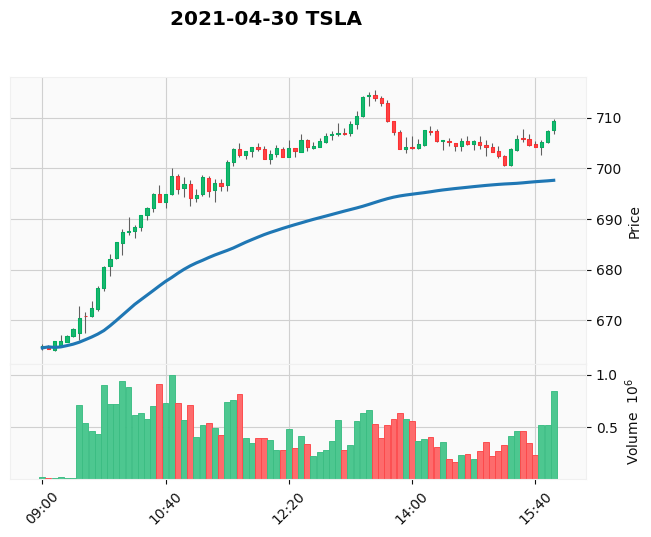

Period's starting TWAP value: 664.55
Period's ending TWAP value: 669.9402020833334
Sold one share for 665.05
Sold one share for 665.05
Sold one share for 665.8
Sold one share for 666.98
Sold one share for 667.55
Sold one share for 670.9444
Sold one share for 665.8
Sold one share for 666.98
Sold one share for 667.55
Sold one share for 670.9444
Sold one share for 670.8074
Sold one share for 672.18
Sold one share for 676.31
Sold one share for 680.72
Sold one share for 670.8074
Sold one share for 672.18
Sold one share for 676.31
Sold one share for 680.72


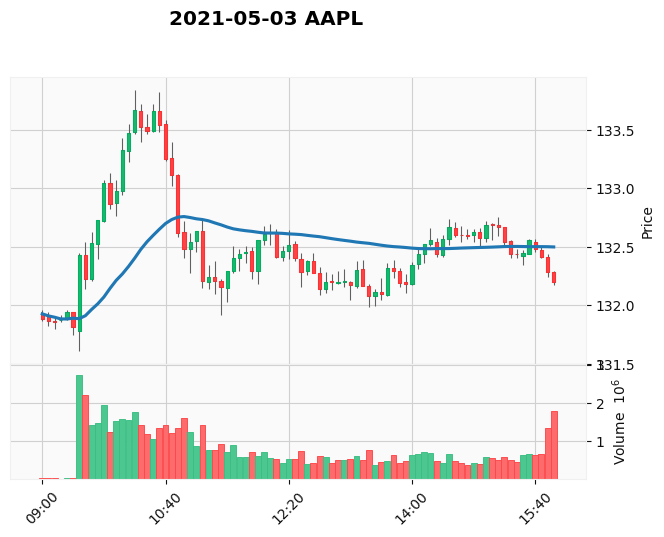

Period's starting TWAP value: 131.9271
Period's ending TWAP value: 132.21403541666666
Purchased one share for 131.8672
Purchased one share for 131.8762
Purchased one share for 131.8672
Purchased one share for 131.8762
Purchased one share for 131.8872
Sold one share for 132.4312
Purchased one share for 131.8872
Sold one share for 132.4312
Sold one share for 132.2266
Sold one share for 132.5261
Sold one share for 132.7208
Sold one share for 133.0452
Sold one share for 132.2266
Sold one share for 132.5261
Sold one share for 132.7208
Sold one share for 133.0452


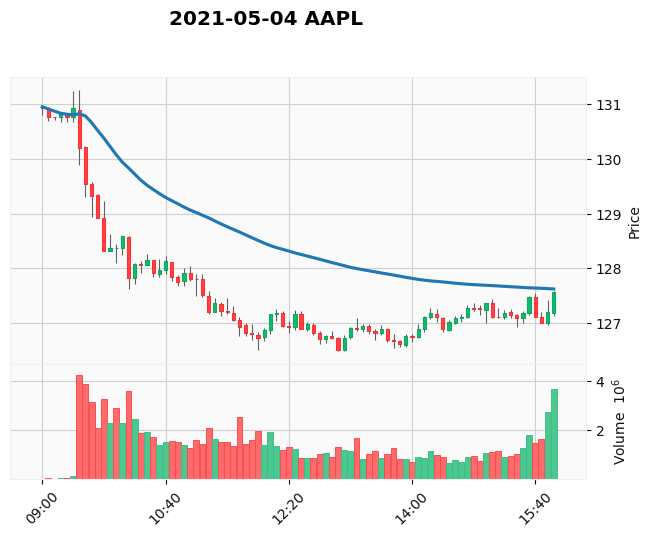

Period's starting TWAP value: 130.9587
Period's ending TWAP value: 130.08049375000002
Purchased one share for 130.779
Purchased one share for 130.7691
Purchased one share for 130.779
Purchased one share for 130.7691
Purchased one share for 130.809
Purchased one share for 130.779
Purchased one share for 130.8988
Purchased one share for 130.22
Purchased one share for 130.809
Purchased one share for 130.779
Purchased one share for 130.8988
Purchased one share for 130.22
Purchased one share for 129.5511
Purchased one share for 129.3401
Purchased one share for 128.9322
Purchased one share for 128.3232
Purchased one share for 129.5511
Purchased one share for 129.3401
Purchased one share for 128.9322
Purchased one share for 128.3232


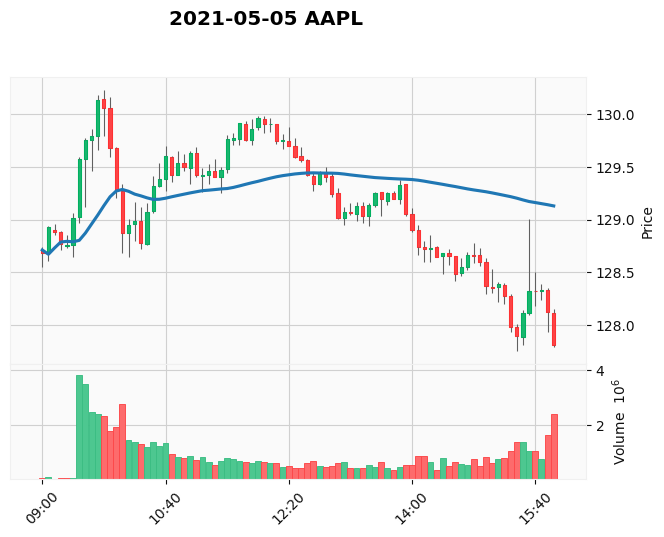

Period's starting TWAP value: 128.7125
Period's ending TWAP value: 129.27167083333336
Sold one share for 128.9022
Sold one share for 128.8822
Sold one share for 128.9022
Sold one share for 128.8822
Sold one share for 128.7525
Sold one share for 128.7624
Sold one share for 129.022
Sold one share for 129.5722
Sold one share for 128.7525
Sold one share for 128.7624
Sold one share for 129.022
Sold one share for 129.5722
Sold one share for 129.7587
Sold one share for 129.7907
Sold one share for 130.1401
Sold one share for 130.0603
Sold one share for 129.7587
Sold one share for 129.7907
Sold one share for 130.1401
Sold one share for 130.0603


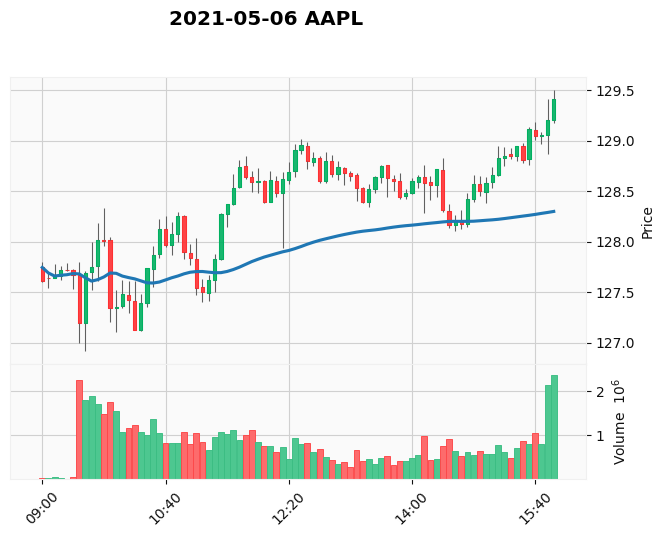

Period's starting TWAP value: 127.7442
Period's ending TWAP value: 127.68600624999999
Purchased one share for 127.6443
Purchased one share for 127.6443
Purchased one share for 127.6643
Purchased one share for 127.6443
Purchased one share for 127.6443
Purchased one share for 127.6643
Purchased one share for 127.1939
Purchased one share for 127.1939


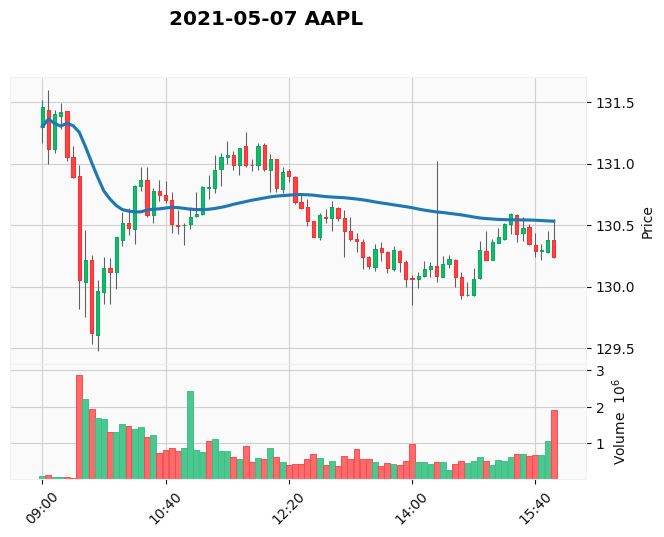

Period's starting TWAP value: 131.3
Period's ending TWAP value: 130.65962916666666
Sold one share for 131.44
Sold one share for 131.39
Sold one share for 131.44
Sold one share for 131.39
Purchased one share for 131.0499
Purchased one share for 130.9
Purchased one share for 130.04
Purchased one share for 131.0499
Purchased one share for 130.9
Purchased one share for 130.04
Purchased one share for 130.22
Purchased one share for 129.61
Purchased one share for 129.96
Purchased one share for 130.15
Purchased one share for 130.22
Purchased one share for 129.61
Purchased one share for 129.96
Purchased one share for 130.15


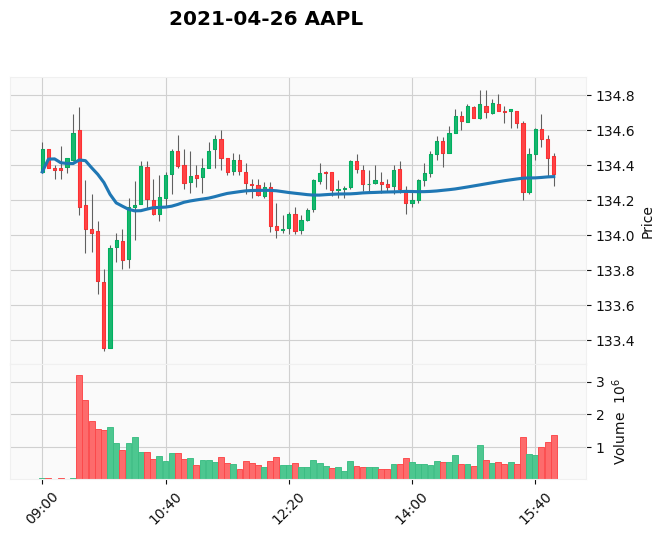

Period's starting TWAP value: 134.362
Period's ending TWAP value: 134.18446875
Sold one share for 134.4928
Sold one share for 134.4928
Purchased one share for 134.1733
Purchased one share for 134.1733
Purchased one share for 134.0335
Purchased one share for 134.0236
Purchased one share for 133.734
Purchased one share for 133.3548
Purchased one share for 134.0335
Purchased one share for 134.0236
Purchased one share for 133.734
Purchased one share for 133.3548


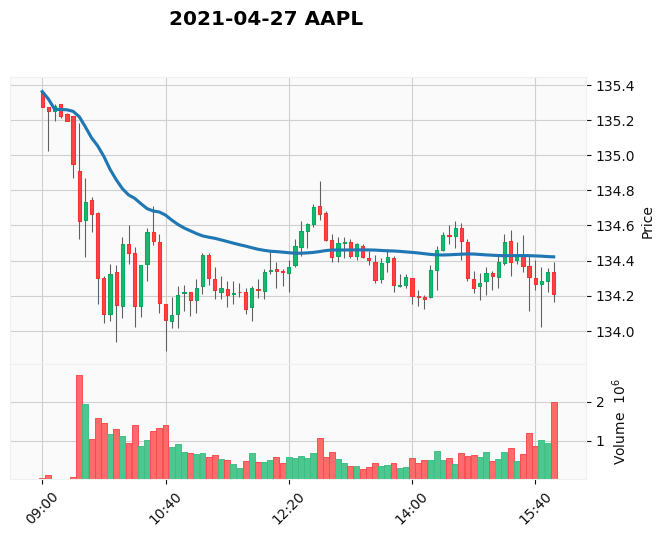

Period's starting TWAP value: 135.3613
Period's ending TWAP value: 134.8599625
Purchased one share for 135.2714
Purchased one share for 135.2515
Purchased one share for 135.2914
Purchased one share for 135.2714
Purchased one share for 135.2515
Purchased one share for 135.2914
Purchased one share for 135.2315
Purchased one share for 135.2215
Purchased one share for 134.9121
Purchased one share for 134.6325
Purchased one share for 135.2315
Purchased one share for 135.2215
Purchased one share for 134.9121
Purchased one share for 134.6325
Purchased one share for 134.7423
Purchased one share for 134.6725
Purchased one share for 134.2981
Purchased one share for 134.0934
Purchased one share for 134.7423
Purchased one share for 134.6725
Purchased one share for 134.2981
Purchased one share for 134.0934


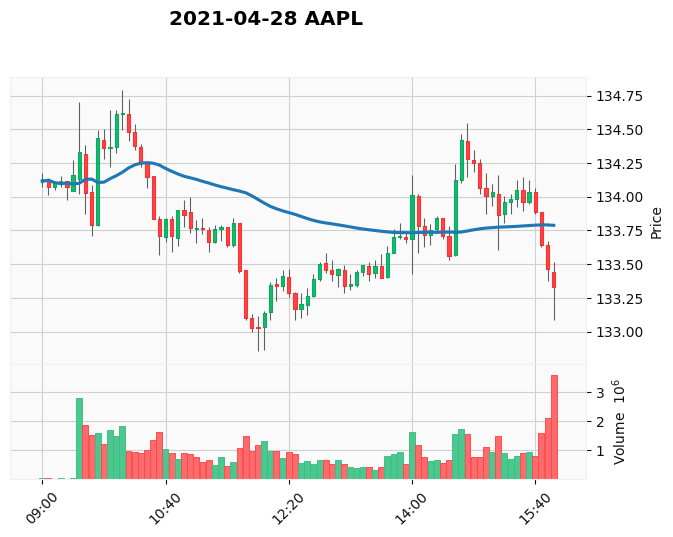

Period's starting TWAP value: 134.1134
Period's ending TWAP value: 134.1559375
Purchased one share for 134.0735
Purchased one share for 134.1034
Purchased one share for 134.0735
Purchased one share for 134.1034
Purchased one share for 134.1134
Purchased one share for 134.0435
Sold one share for 134.1334
Sold one share for 134.3142
Purchased one share for 134.1134
Purchased one share for 134.0435
Sold one share for 134.1334
Sold one share for 134.3142
Sold one share for 134.4229
Sold one share for 134.363
Sold one share for 134.4229
Sold one share for 134.363


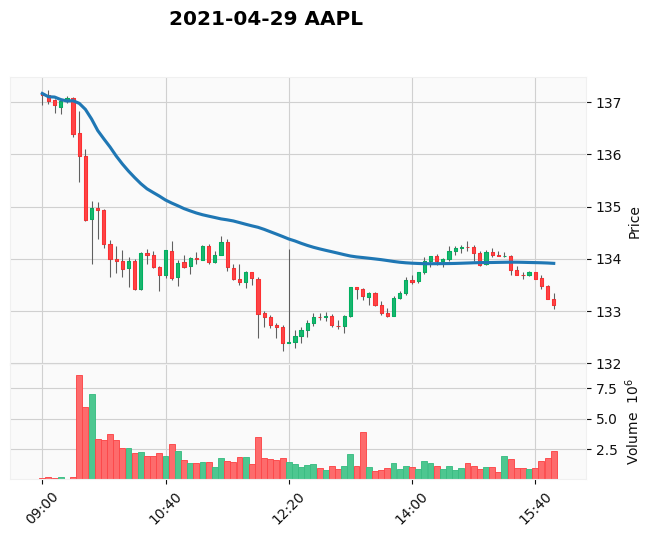

Period's starting TWAP value: 137.1682
Period's ending TWAP value: 135.9693125
Purchased one share for 137.0385
Purchased one share for 136.9087
Purchased one share for 137.0385
Purchased one share for 136.9087
Purchased one share for 137.0185
Purchased one share for 136.4095
Purchased one share for 135.9702
Purchased one share for 137.0185
Purchased one share for 136.4095
Purchased one share for 135.9702
Purchased one share for 134.7523
Purchased one share for 134.9819
Purchased one share for 134.932
Purchased one share for 134.2816
Purchased one share for 134.7523
Purchased one share for 134.9819
Purchased one share for 134.932
Purchased one share for 134.2816


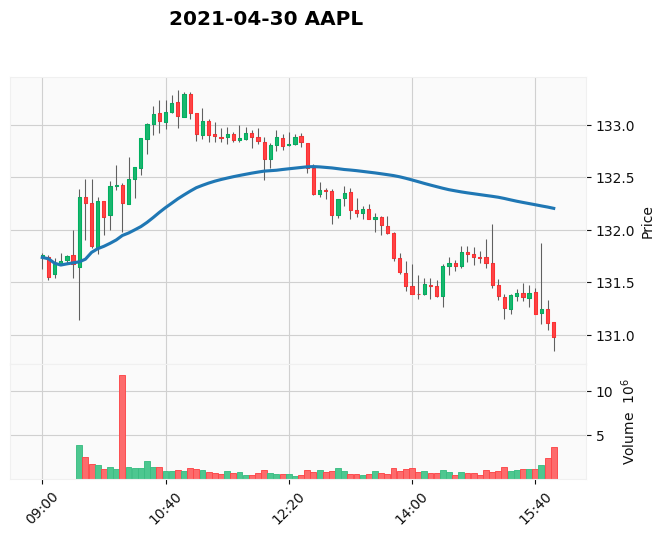

Period's starting TWAP value: 131.7374
Period's ending TWAP value: 131.90397291666665
Purchased one share for 131.5777
Purchased one share for 131.6775
Purchased one share for 131.5777
Purchased one share for 131.6775
Purchased one share for 131.7175
Sold one share for 132.3164
Purchased one share for 131.7175
Sold one share for 132.3164
Sold one share for 132.2516
Sold one share for 131.8373
Sold one share for 132.2754
Sold one share for 132.1417
Sold one share for 132.2516
Sold one share for 131.8373
Sold one share for 132.2754
Sold one share for 132.1417


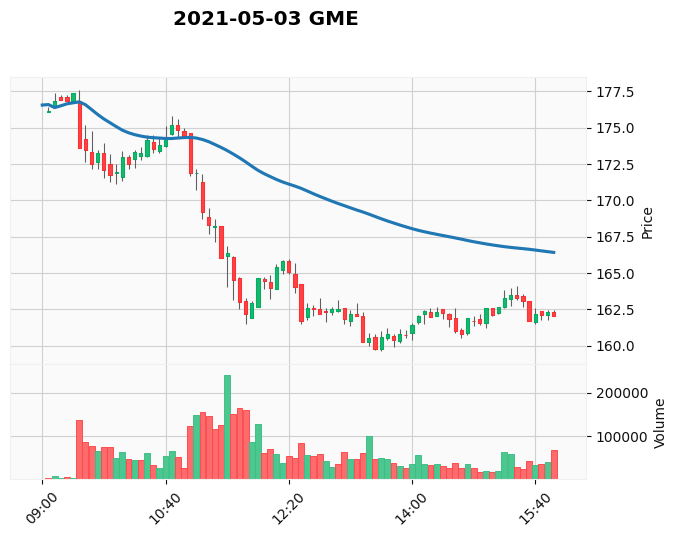

Period's starting TWAP value: 176.55
Period's ending TWAP value: 175.0693229166667
Purchased one share for 176.06
Sold one share for 177.1
Purchased one share for 176.06
Sold one share for 177.1
Sold one share for 177.1
Sold one share for 176.8
Purchased one share for 174.2453
Sold one share for 177.1
Sold one share for 176.8
Purchased one share for 174.2453
Purchased one share for 173.3
Purchased one share for 172.605
Purchased one share for 173.256
Purchased one share for 172.5
Purchased one share for 173.3
Purchased one share for 172.605
Purchased one share for 173.256
Purchased one share for 172.5


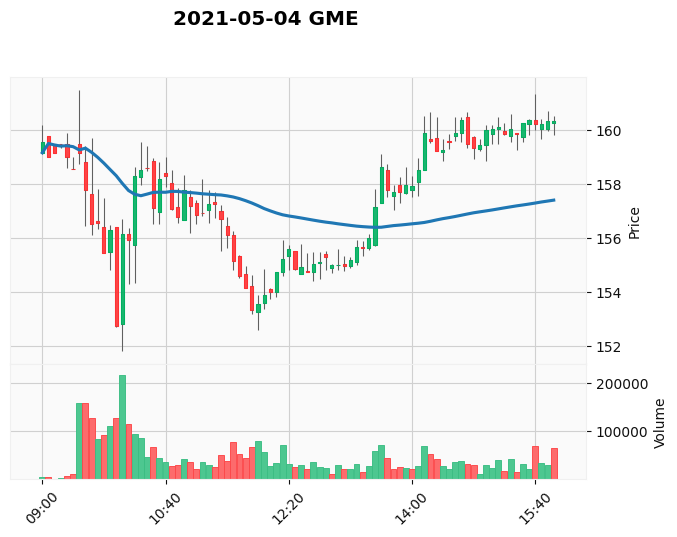

Period's starting TWAP value: 159.16
Period's ending TWAP value: 158.30622083333333
Sold one share for 159.77
Sold one share for 159.77
Purchased one share for 158.55
Purchased one share for 158.81
Purchased one share for 158.55
Purchased one share for 158.81
Purchased one share for 157.61
Purchased one share for 156.63
Purchased one share for 156.4
Purchased one share for 155.47
Purchased one share for 157.61
Purchased one share for 156.63
Purchased one share for 156.4
Purchased one share for 155.47


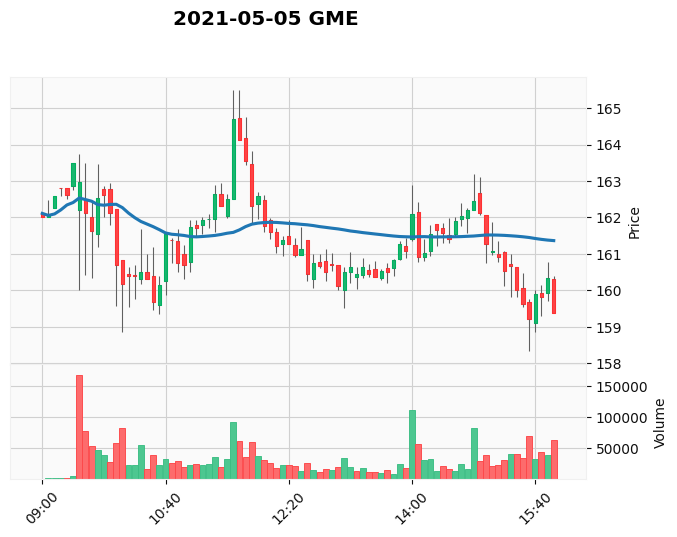

Period's starting TWAP value: 162.11
Period's ending TWAP value: 162.36023125000003
Sold one share for 162.25
Sold one share for 162.8
Sold one share for 162.25
Sold one share for 162.8
Sold one share for 162.8
Sold one share for 162.85
Sold one share for 162.21
Sold one share for 162.51
Sold one share for 162.8
Sold one share for 162.85
Sold one share for 162.21
Sold one share for 162.51
Purchased one share for 162.0
Sold one share for 162.77
Sold one share for 162.79
Purchased one share for 162.0
Sold one share for 162.77
Sold one share for 162.79


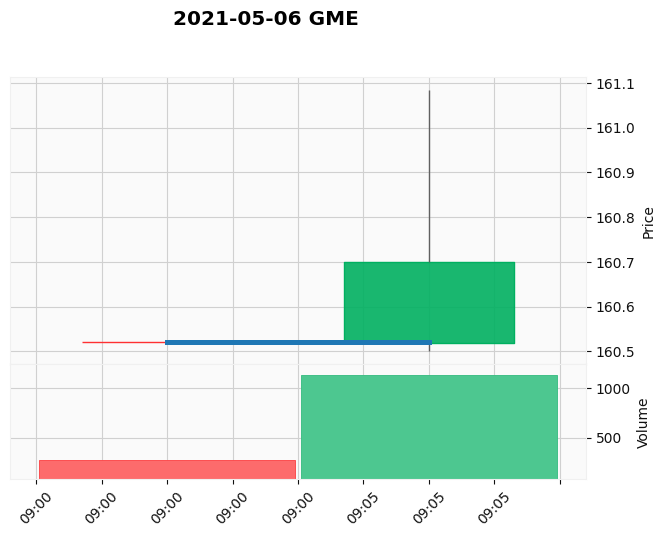

Period's starting TWAP value: 160.52


IndexError: list index out of range

In [40]:
def main(argv):
    
    cores = int(argv[-1])
    
    argv.pop()

    for stock in argv:
        multi(stock, 1000, cores, add_vwap=1, add_twap=1)

#Default execution
if __name__ == '__main__':
    #list of tickers
    args = ['TSLA','AAPL','GME','AMZN','MSFT']
    cores = '1';
    
    args.append(cores)
    
    #call main
    main(args)
